<a href="https://colab.research.google.com/github/SudeepSarkar/Computer-Vision-Course/blob/main/Lecture_8_SIFT_HOG_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The SIFT (Scale-Invariant Feature Transform) Detector and Descriptor

D. G. Lowe, "[Object recognition from local scale-invariant features](https://ieeexplore.ieee.org/document/790410)," Proceedings of the Seventh IEEE International Conference on Computer Vision, Kerkyra, Greece, 1999, pp. 1150-1157 vol.2, doi: 10.1109/ICCV.1999.790410.

David G. Lowe, "[Distinctive image features from scale-invariant keypoints](https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf)," International Journal of Computer Vision, 60, 2 (2004), pp. 91-110. 


David Lowe's webpage: [The SIFT Keypoint Detector](https://www.cs.ubc.ca/~lowe/keypoints/)



# Motivation
1. The Harris points are not invariant to scale and or rotation.
2. Scale and rotation are an issue when matching images, either across views or time.
3. Lowe aimed to formulate a new detector for significant points and a robust descriptor to the variations corresponding to typical viewing conditions. The descriptor is the most-used part of SIFT.




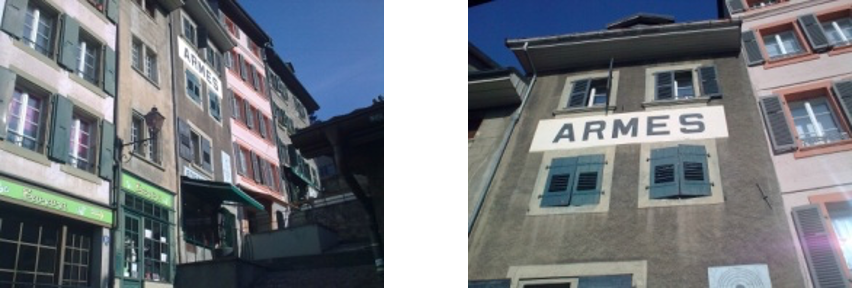

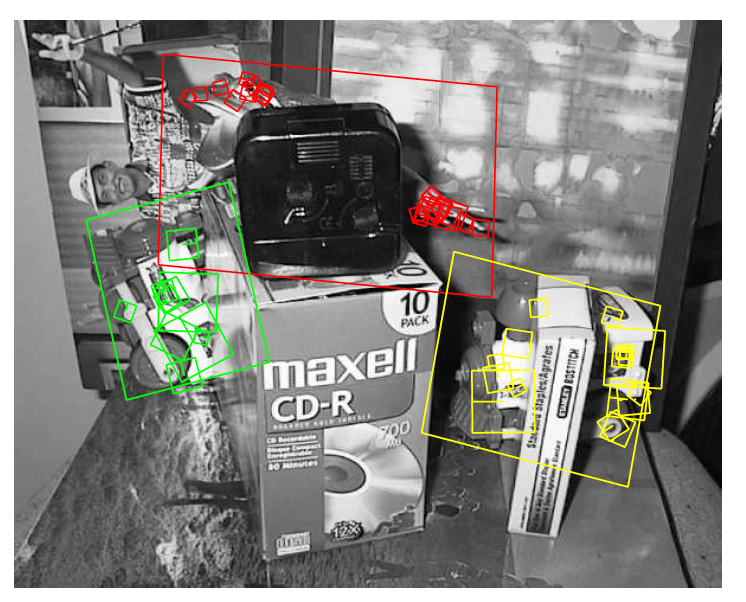

# Four Steps
1. Scale-space extrema detection by searching over multiple scales and locations
2. Keypoint localization by fitting a model to estimate the local scale and select keypoint based on stability.
3. Orientation assignment to each local region to capture salient local orientation. This is useful in rotation invariant matching
4. Keypoint description using local image gradients, choosing the right scale, and factoring out the local rotation, resulting in a robust descriptor.

# 1. Scale-space extrema detection

* Search for stable features across multiple scales using a continuous function of scale. So, we have to create a scale space.
* The scale space of an image is a **continuous** function $L(x,y,\sigma)$ produced from the convolution of a Gaussian kernel (at different scales) with the input image.

\begin{eqnarray}
L(x,y,\sigma) & = & f(x, y) \star G(x, y, \sigma) \\
&  = & \int_x \int_y f(u, v) G(u - x, v - y, \sigma) dx dy
\end{eqnarray}

>> See ([Lindeberg, 1998](https://people.kth.se/~tony/papers/cvap222.pdf)) for a detailed mathematical exposition of the important concept of scale.

* Under various assumptions, the best function for creating an image scale space is a Gaussian function. 

* An important property is

\begin{eqnarray}
\frac{\partial}{\partial \sigma} G(x, y, \sigma) & = & \sigma \nabla^2 G(x, y, \sigma) \\
& \approx & \frac{G(x, y, k\sigma) - G(x, y, \sigma)}{(k-1)\sigma} \\
G(x, y, k\sigma) - G(x, y, \sigma) & \approx & (k-1)\sigma^2 \nabla^2 G(x, y, \sigma)
\end{eqnarray}

* Here is the mathematical reason why the difference of Gaussian (DoG) was similar to the Laplacian of Gaussian (LoG) output we had observed earlier.

* Ideally, $k$ should be small. For the current purposes $k=2^{\frac{1}{s}}$ performed well, where $s=3$ resulted in the most stable keypoints.

* In practice, we use a discretized version of the scale space, called the image pyramid. 

* As we have seen earlier, LoG tends to emphasize corners and edges. We consider an image pyramid of LoG. However, we can construct this pyramid from Gaussian scale space.

* For each octave of scale space, the initial image is repeatedly convolved with Gaussians to produce the set of scale-space images shown on the left. We subtract adjacent Gaussian images to create the difference-of-Gaussian images on the right. After each octave, the Gaussian image is down-sampled by a factor of 2, and the process is repeated.

* Lowe used three scales per octave. The number of octaves was 4. However, this is dependent on the image size. Larger images probably need more octaves. For very low-resolution images, you probably wouldn't need that many octaves. Lowe used a starting sigma value of 1.6, but that depends on the quality of the image you have.


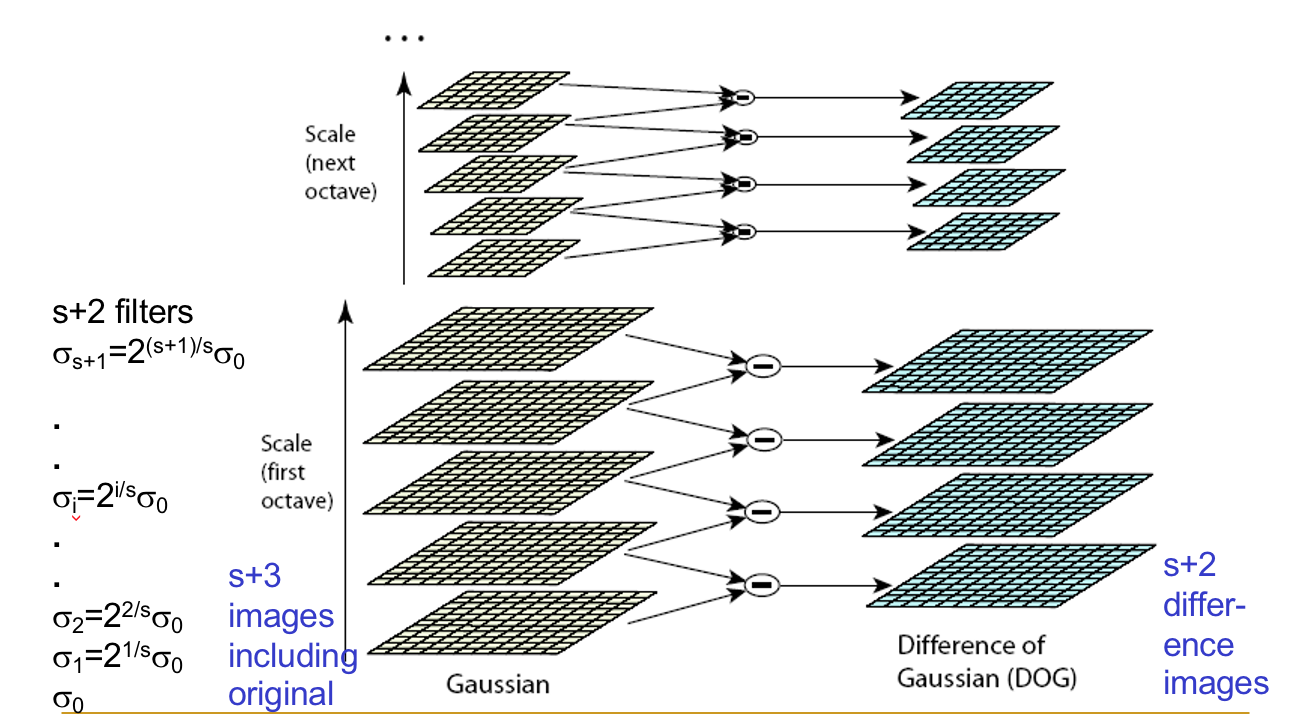![image.png]()

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/Colab\ Notebooks/data/

Mounted at /content/drive
'Armes 1.png'				    lizard.jpg
'Armes 2.png'				    MOT16-08-raw.webm
 blog_danforth_monica_mural_panorama.jpg    mountain_peak_1.png
 blog_monica_mural_brown_white.jpg	    mountain_peak_2.png
 blog_monica_mural_fish_tree_windows1.jpg   parking_lot_meva_1.png
 hawaii.png				    parking_lot_meva_2.png
 house_1.png				    parking_lot_meva_3.png
 house_2.png				    window_1.png
 house_facade.png			    window_2.png


In [2]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import scipy.ndimage as scimage
import torch.nn as nn
from skimage import io
from skimage.feature import peak_local_max
!pip install opencv-contrib-python==4.4.0.44
import cv2
print (cv2 .__version__)


np.set_printoptions(precision=2, suppress=True)

     |████████████████████████████████| 55.7MB 76kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30
4.4.0


Input image size: (302, 400)


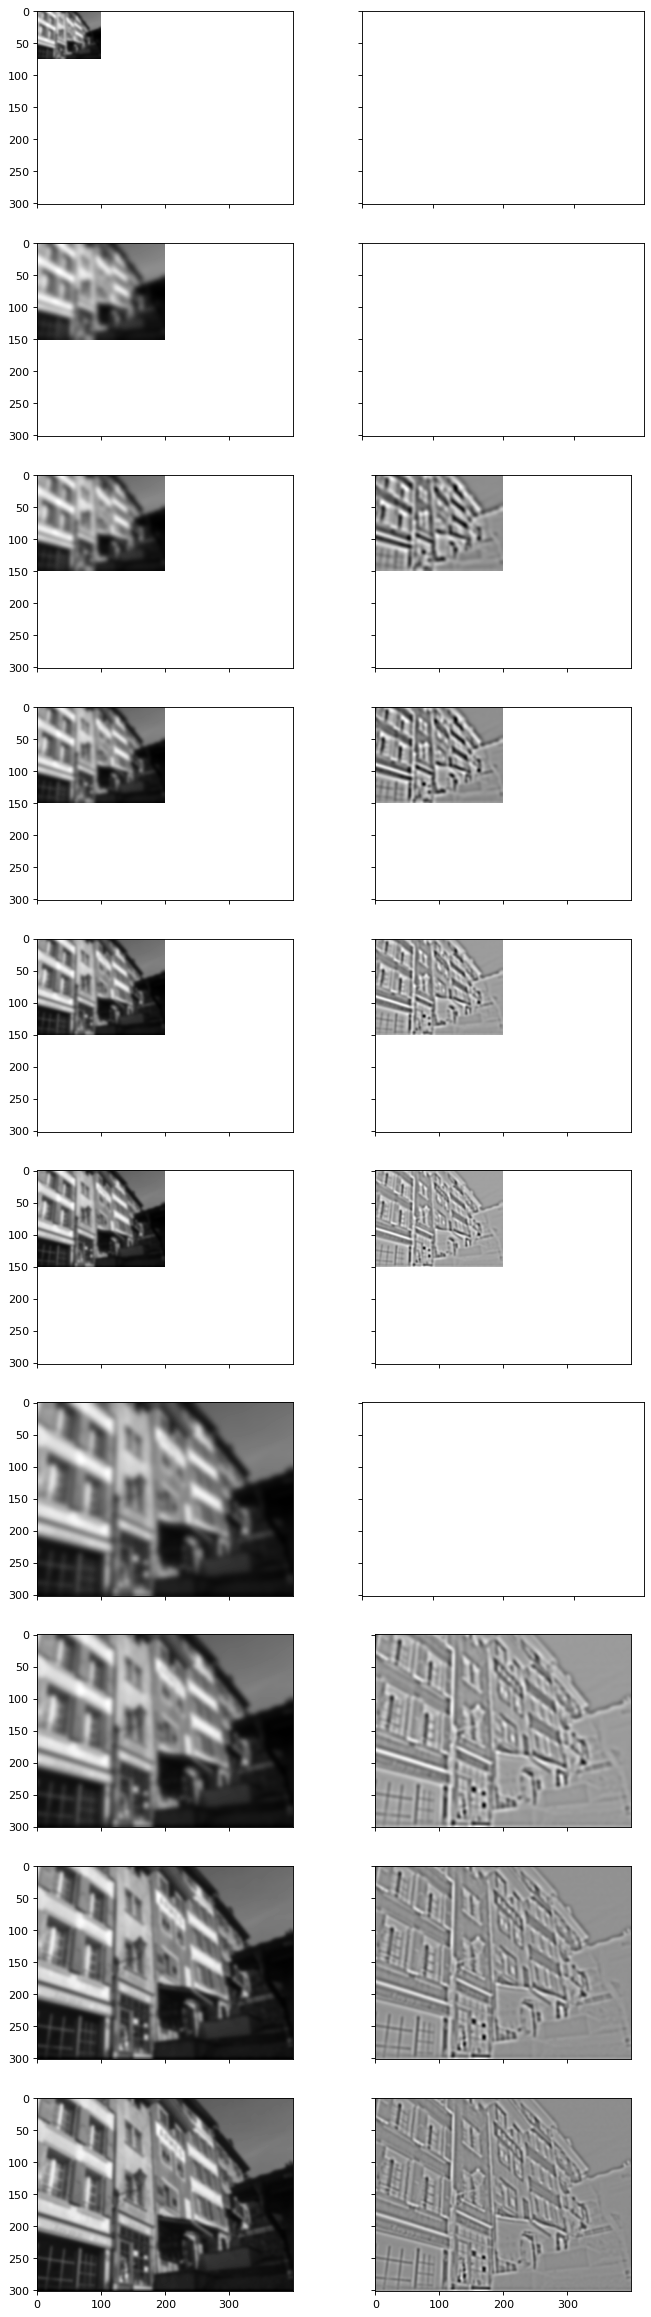

In [6]:
def gaussian (x, sigma):
    g = np.exp(-(x**2/(2*sigma*sigma)))*(1/(np.sqrt(2*np.pi)*sigma))
    return (g/g.sum())

#------------------------------------------------------------------
def image_convolve_gaussian (image, sigma) :
    N = np.round(3*(sigma+1))
    t = np.arange(-N, N)  # Note the width of the kernel, need to be this large to capture most of the shape
    g = gaussian(t, sigma) # 1D gaussian kernel
    # Process rows
    output = image.copy()
    for i in range (image.shape[0]):
        output[i,:] = scimage.convolve(output[i, :], g)
    # Process columns
    for j in range (image.shape[1]):
        output[:, j] = scimage.convolve(output[:, j], g)
    return (output)

# Load an color image in grayscale
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/Armes 1.png')

# Change color spaces. Can experiment with other spaces.
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("Input image size:", img.shape)
img = img.astype(np.float)  # need to change type from uint8 to float

# First octave stack -- created by repeated convolution with a Gaussian function with 
# sigma = np.power(2, 1/3), s=3 (see Lowe's paper for what the parameter s is about)
Gaussian_image_1_0 = image_convolve_gaussian (img, 2.0) #sigma = 2.0
height_1_0, width_1_0 = Gaussian_image_1_0.shape
Gaussian_image_1_1 = image_convolve_gaussian (Gaussian_image_1_0, np.power(2, 1/3)) #effective sigma = 2.51
Gaussian_image_1_2 = image_convolve_gaussian (Gaussian_image_1_1, np.power(2, 2/3)) #sigma = 3.17
Gaussian_image_1_3 = image_convolve_gaussian (Gaussian_image_1_2, np.power(2, 3/3)) #sigma = 4.0
Gaussian_image_1_4 = image_convolve_gaussian (Gaussian_image_1_3, np.power(2, 3/3)) #sigma = 5.0
# Second octave stack, first image, reduced size
Gaussian_image_2_0 =  Gaussian_image_1_3 [1:height_1_0:2, 1:width_1_0:2]            #sigma = 4.0
height_2_0, width_2_0 = Gaussian_image_2_0.shape
Gaussian_image_2_1 = Gaussian_image_1_4 [1:height_1_0:2, 1:width_1_0:2]             #sigma = 5.0
Gaussian_image_2_2 = image_convolve_gaussian (Gaussian_image_2_1, np.power(2, 2/3)) #sigma = 6.3
Gaussian_image_2_3 = image_convolve_gaussian (Gaussian_image_2_2, np.power(2, 3/3)) #sigma = 8.0
Gaussian_image_2_4 = image_convolve_gaussian (Gaussian_image_2_3, np.power(2, 3/3)) #sigma = 10.0

# Third octave stack, first image, reduced size
Gaussian_image_3_0 =  Gaussian_image_2_3 [1:height_2_0:2, 1:width_2_0:2] #sigma = 8.0

#------------------display-----------------------------------------
dpi = 80

# What size does the figure need to be in inches to fit the image?
figsize = 2*width_1_0 / float(dpi), 10*height_1_0/ float(dpi)
fig, ax = plt.subplots(nrows=10, ncols=2, figsize=figsize, dpi=dpi, sharex=True, sharey=True)

ax[0,0].imshow(Gaussian_image_3_0, 'gray')
#plt.title('Next octave, subsampled with $\sigma=8$')

ax[1,0].imshow(Gaussian_image_2_4, 'gray')
#plt.title('Next octave, subsampled with $\sigma=10.0$')

ax[2,0].imshow(Gaussian_image_2_3, 'gray')
#plt.title('Next octave, subsampled with $\sigma=8$')
ax[2,1].imshow(Gaussian_image_2_4-Gaussian_image_2_3, 'gray')

ax[3,0].imshow(Gaussian_image_2_2, 'gray')
#plt.title('smoothed with $\sigma_0=6.3$')
ax[3,1].imshow(Gaussian_image_2_3-Gaussian_image_2_2, 'gray')

ax[4,0].imshow(Gaussian_image_2_1, 'gray')
#plt.title('smoothed with $\sigma=2(2^{1/3})=5.0$')
ax[4,1].imshow(Gaussian_image_2_2-Gaussian_image_2_1, 'gray')

ax[5,0].imshow(Gaussian_image_2_0, 'gray')
#plt.title('smoothed with $\sigma=2(2^{2/3}=)=4.0$')
ax[5,1].imshow(Gaussian_image_2_1-Gaussian_image_2_0, 'gray')

ax[6,0].imshow(Gaussian_image_1_4, 'gray')
#plt.title('smoothed with $\sigma=2(2^{3/3}=5.0)$')

ax[7,0].imshow(Gaussian_image_1_3, 'gray')
#plt.title('LoG or DoG ($\sigma=2.51, \sigma_0=4.0$)')
ax[7,1].imshow(Gaussian_image_1_4-Gaussian_image_1_3, 'gray')


ax[8,0].imshow(Gaussian_image_1_2, 'gray')
#plt.title('LoG or DoG ($\sigma=3.17, \sigma=3.17$)')
ax[7,1].imshow(Gaussian_image_1_3-Gaussian_image_1_2, 'gray')

ax[8,0].imshow(Gaussian_image_1_1, 'gray')
#plt.title('LoG or DoG ($\sigma = 4, \sigma=2.51$)');
ax[8,1].imshow(Gaussian_image_1_2-Gaussian_image_1_1, 'gray')


ax[9,0].imshow(Gaussian_image_1_0, 'gray')
#plt.title('LoG or DoG ($\sigma = 4, \sigma=2.0$)');
ax[9,1].imshow(Gaussian_image_1_1-Gaussian_image_1_0, 'gray')



# 2. Key Point Localization

Detect maxima and minima of difference-of-Gaussian in scale space

Each point is compared to its 8 neighbors in the current image and 9 neighbors each in the scales above and below.

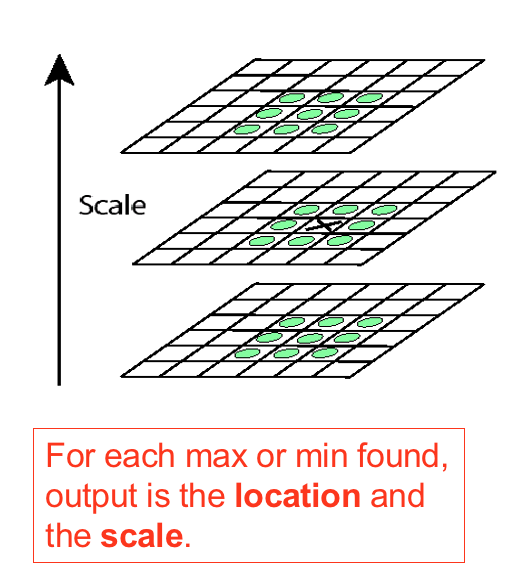


* Once a keypoint candidate has been found by comparing a pixel to its neighbors, the next step is to perform a precise fit to the nearby data for location, scale, and the ratio of principal curvatures.

* This information allows points to be rejected that have low contrast (and are
therefore sensitive to noise) or are poorly localized along an edge.

* The [Hessian matrix ](https://en.wikipedia.org/wiki/Hessian_matrix)help eliminate edge responses based on curvature. A poorly defined peak in the difference-of-Gaussian function will have a sizeable principal curvature across the edge but a small one in the perpendicular direction. The derivatives are estimated by taking differences of neighboring sample points.

\begin{equation}
{\bf H} = \left [ \begin{matrix} \frac{\partial^2}{\partial^2 x} D & \frac{\partial^2}{\partial x \partial y} D \\ \frac{\partial^2}{\partial y \partial x} D & \frac{\partial^2}{\partial^2 x} D \end{matrix} \right ]
\end{equation}


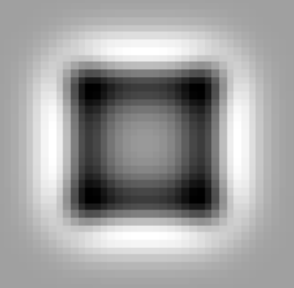

# 3. Orientation Estimation
* The keypoint scale is used to select the Gaussian smoothed image, $L$, with the closest scale so that all computations are performed in a scale-invariant manner. 

* For each image sample, $L(x, y)$, at this scale, the gradient magnitude, $m(x, y)$, and orientation, $(x, y)$, are precomputed using pixel differences to approximate the derivative operation.

* An orientation histogram is formed from the gradient orientations of sample points within a region around the keypoint. The orientation histogram has 36 bins covering the 360-degree range of directions. Each sample added to the histogram is weighted by its gradient magnitude and by a Gaussian-weighted circular window with  1.5 times that of the keypoint scale.

* Peaks in the orientation histogram correspond to dominant directions of local gradients. The highest peak in the histogram is detected, and then any other local peak within 80% of the highest peak is also used to create a keypoint with that orientation.

* Each key specifies stable 2D coordinates (x, y, scale, orientation)



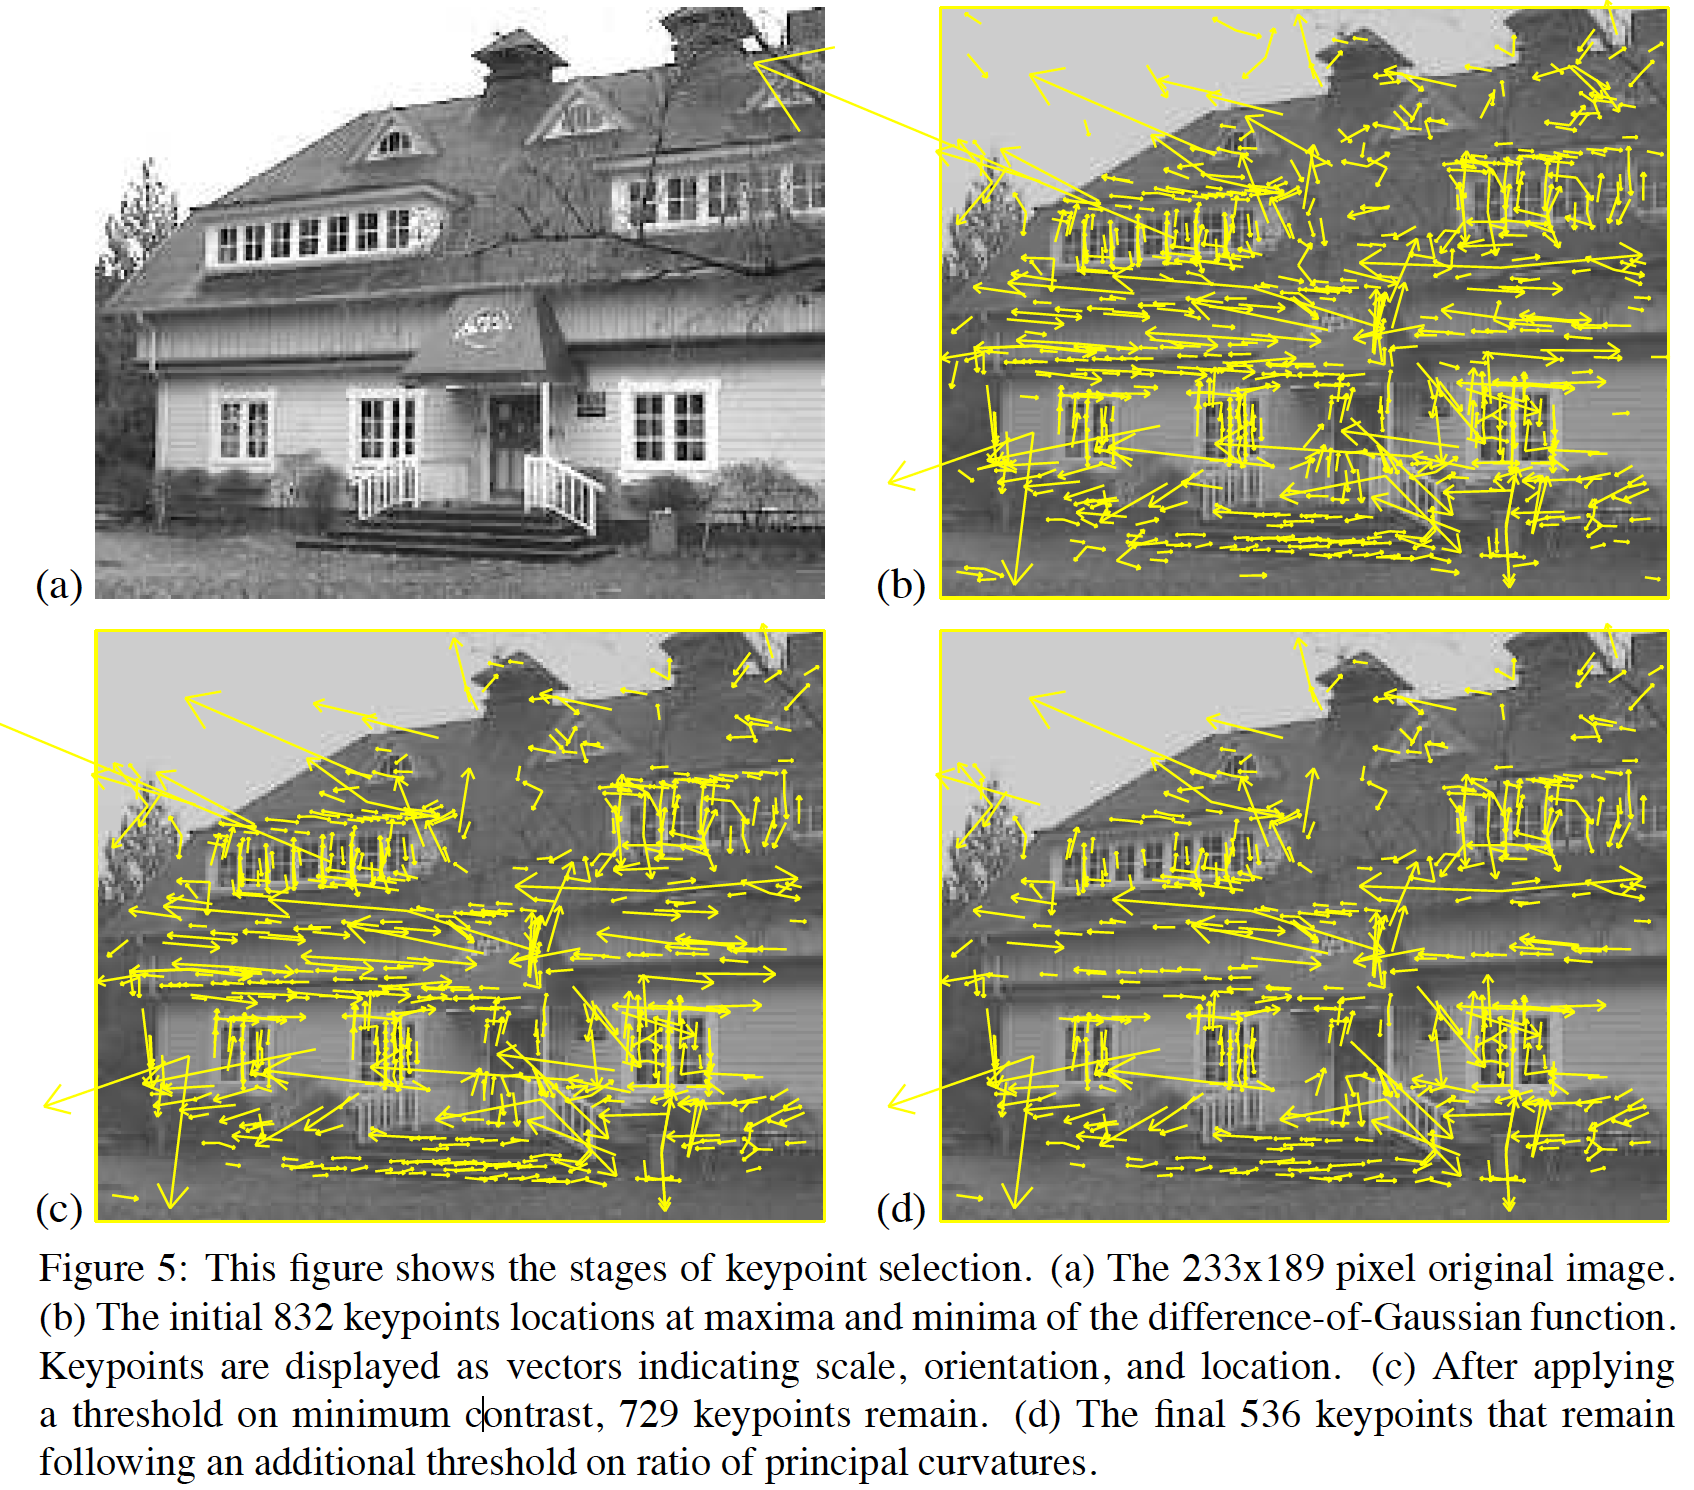

# Keypoint localization with orientation

1. Rotate the window to standard orientation

2. Scale the window size based on the scale at which the point was found.

# 4. SIFT Keypoint Descriptor
1. Use the normalized region about the keypoint
2. Compute gradient magnitude and orientation at each point in the region
3. Weight them by a Gaussian window overlaid on the circle
4. Create an orientation histogram over the 4 X 4 subregions of the window
5. 4 X 4 descriptors over 16 X 16 sample array were used in practice. 4 X 4 times 8 directions gives a vector of 128 values.

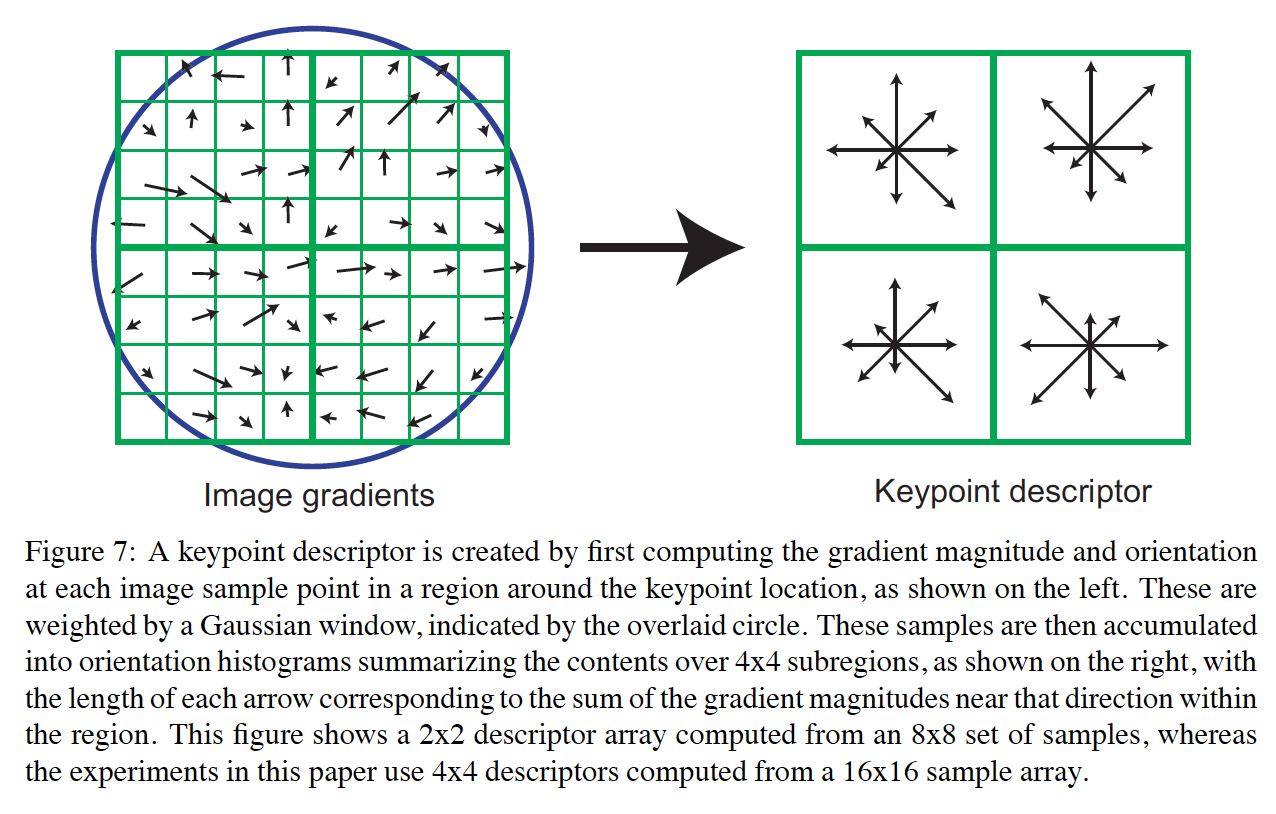

# OpenCV SIFT detector and descriptor

The OpenCV tutorial below is worth reading; however, note that the code snippets used are for cv and not for cv2. 

https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html


There is also a standalone python implementation that seems to be good. However, I have not tried or vetted it to evaluate the implementation's fidelity to the original Lowe paper. If you want, you can experiment with it.
https://github.com/rmislam/PythonSIFT



Input image size: (174, 246)

 Keypoint #5 (of 203) in (image 1):
 angle=91.50, (octave, layer, scale)=-1.00 2.00 2.00, size=2.69, pt=(13.58617115020752, 121.140380859375)

Note: 2^octave * scale = 1. So, octave = -1 => scale = 2

 Keypoint 5 descriptor (image 1): Shape(203, 128), Values[5]=
[ 17.  93.  73.  16.   9.   2.   0.   2.  11.  20.  56.  62.  78.  29.
  27.  16.   0.   9.  36.  17.  14.  65.  32.   3.   0.   0.   3.   8.
   8.   9.   9.   0.  25.  10.  21.  10.   9.   2.   0.   2. 131.  27.
  11.   4.   2.  38.  53.  91.  22.   7.   7.  10.  12. 131. 131.  25.
   0.   0.   0.   0.   6. 131.  32.   0.  16.  15.   7.   8.  26.  18.
   2.   1. 131. 131.  53.   6.   1.   3.   2.  11.  21. 131. 131.  37.
  13.  61.   9.   4.   2.  45.  10.   3.  17. 131.   7.   0.   6.   1.
   0.   9.  62.   8.   2.  13.  14.  31.  18.   4.   3.   2.   4.  27.
   2. 115.  53.   8.   6.   2.   1.   1.   7. 131.  11.   1.   4.  17.
   4.   0.]

 Matches: # = 103, 7th entry: distance = 472.0 between 

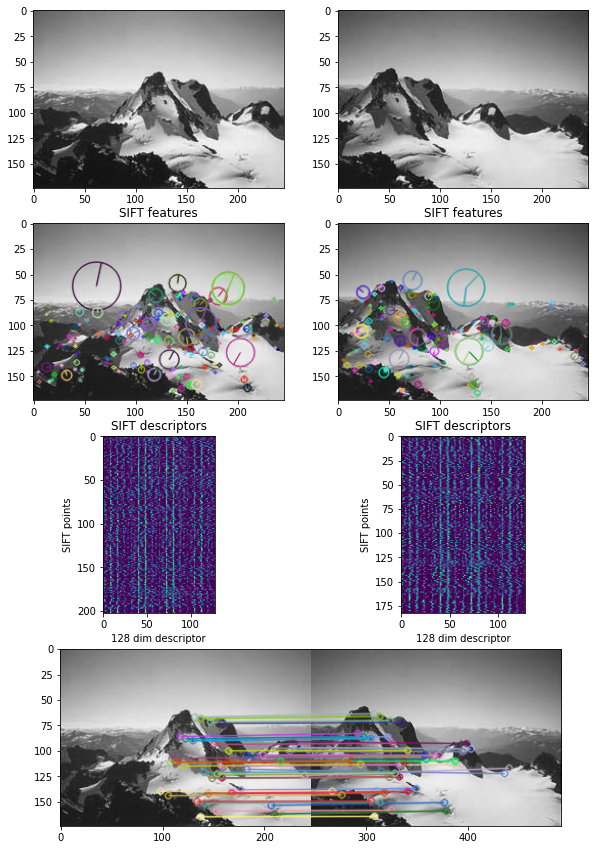

In [8]:
image_1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/mountain_peak_1.png')
image_2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/mountain_peak_2.png')

image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
print("Input image size:", image_1.shape)

sift = cv2.SIFT_create()
# For more details see https://docs.opencv.org/master/d7/d60/classcv_1_1SIFT.html
# Default values
# static Ptr<SIFT> cv::SIFT::create	(	int 	nfeatures = 0,
# int 	nOctaveLayers = 3,
# double 	contrastThreshold = 0.04,
# double 	edgeThreshold = 10,
# double 	sigma = 1.6 
# )	
#
# nfeatures: The number of best features to retain. The features are ranked by their scores 
#           (measured in SIFT algorithm as the local contrast)
# nOctaveLayers: The number of layers in each octave. 3 is the value used in D. Lowe paper. 
#           The number of octaves is computed automatically from the image resolution. 
# contrastThreshold: The contrast threshold used to filter out weak features in semi-uniform 
#           (low-contrast) regions. The larger the threshold, the less features are produced by 
#           the detector. 
# edgeThreshold: The threshold used to filter out edge-like features. Note that the its meaning 
#           is different from the contrastThreshold, i.e. the larger the edgeThreshold, the less 
#           features are filtered out (more features are retained).
# sigma: The sigma of the Gaussian applied to the input image at the octave #0. If your image is 
#           captured with a weak camera with soft lenses, you might want to reduce the number.	

keypoints_1, descriptors_1 = sift.detectAndCompute(image_1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(image_2, None)

# Keypoint class is described in at https://docs.opencv.org/master/d2/d29/classcv_1_1KeyPoint.html
# It is a data structure for salient point detectors in OpenCV. The class instance stores a keypoint, 
# i.e. a point feature found by one of many available keypoint detectors, such as Harris 
# corner detector, FAST, StarDetector, SURF, SIFT etc.
# The keypoint is characterized by the 2D position, scale (proportional to the diameter of the 
# neighborhood that needs to be taken into account), orientation and some other parameters. 
# The keypoint neighborhood is then analyzed by another algorithm that builds a descriptor 
# (usually represented as a feature vector). The keypoints representing the same object in 
# different images can then be matched using KDTree or another method.
def unpackSIFTOctave(keypoint):
    """unpackSIFTOctave(kpt)->(octave,layer,scale)
    @created by Silencer at 2018.01.23 11:12:30 CST
    @brief Unpack Sift Keypoint by Silencer
    @param kpt: cv2.KeyPoint (of SIFT)
    """
    _octave = keypoint.octave
    octave = _octave&0xFF
    layer  = (_octave>>8)&0xFF
    if octave>=128:
        octave |= -128
    if octave>=0:
        scale = float(1/(1<<octave))
    else:
        scale = float(1<<-octave)
    return (octave, layer, scale)

#for i in range(len(keypoints_1)) :
i = 5
octave, layer, scale = unpackSIFTOctave(keypoints_1[i])
print('\n Keypoint #{} (of {}) in (image 1):\n angle={:0.2f}, (octave, layer, scale)={:0.2f} {:0.2f} {:0.2f}, size={:0.2f}, pt={}\n'.format(i, len(keypoints_1), keypoints_1[i].angle, 
                                                                    octave, layer, scale,
                                                                    keypoints_1[i].size, 
                                                                    keypoints_1[i].pt))
print('Note: 2^octave * scale = 1. So, octave = -1 => scale = 2')
print('\n Keypoint {} descriptor (image 1): Shape{}, Values[5]=\n{}'.format(i, descriptors_1.shape, descriptors_1[i,:]))

# FEATURE MATCHING
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
# This is Brute Force OpenCV matcher: https://docs.opencv.org/master/d3/da1/classcv_1_1BFMatcher.html
# For each descriptor in the first set, this matcher finds the closest descriptor in the second set 
# by trying each one. This descriptor matcher supports masking permissible matches of descriptor sets.
# crossCheck -- If it is false, this is will be default BFMatcher behaviour when it finds the 
#               k nearest neighbors for each query descriptor. If crossCheck==TRUE, then the 
#               knnMatch() method with k=1 will only return pairs (i,j) such that for i-th query 
#               descriptor the j-th descriptor in the matcher's collection is the nearest and vice versa, 
#               i.e. the BFMatcher will only RETURN CONSISTENT pairs. Such technique usually produces best 
#               results with minimal number of outliers when there are enough matches. This is alternative 
#               to the ratio test, used by D. Lowe in SIFT paper.

matches = bf.match(descriptors_1, descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

# The match class is described here: https://docs.opencv.org/master/d4/de0/classcv_1_1DMatch.html
print('\n Matches: # = {}, 7th entry: distance = {} between features {} (of {}) and {} \n'.format(len(matches), 
                                                                                      matches[7].distance,
                                                                                      matches[7].trainIdx,
                                                                                      matches[7].imgIdx,
                                                                                      matches[7].queryIdx))

#----------------------------------Display-------------------------------------------------------
# draw the detected key points for display purposes
sift_image1 = cv2.drawKeypoints(image_1, keypoints_1, image_1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
sift_image2 = cv2.drawKeypoints(image_2, keypoints_2, image_2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# draw matches
match_image = cv2.drawMatches(image_1, keypoints_1, image_2, keypoints_2, matches[:50], image_2, flags=2)

plt.figure(figsize=(10,15))
plt.subplot(421)
plt.imshow(image_1, 'gray')
plt.subplot(422)
plt.imshow(image_2, 'gray')
plt.subplot(423)
plt.imshow(sift_image1)
plt.title('SIFT features')
plt.subplot(424)
plt.imshow(sift_image2)
plt.title('SIFT features')
plt.subplot(425)
plt.imshow(descriptors_1)
plt.title('SIFT descriptors')
plt.ylabel('SIFT points')
plt.xlabel('128 dim descriptor')
plt.subplot(426)
plt.imshow(descriptors_2)
plt.title('SIFT descriptors')
plt.ylabel('SIFT points')
plt.xlabel('128 dim descriptor')
plt.subplot(414)
plt.imshow(match_image)

# save the image
# cv2.imwrite("table-sift.jpg", sift_image)
cv2.waitKey(0)
cv2.destroyAllWindows()





# Histogram of Oriented Gradients (HOG) descriptor

This descriptor is another well-known descriptor popular in computer vision works but suitable for **regions**. 

N. Dalal and B. Triggs, "[Histograms of oriented gradients for human detection](https://ieeexplore.ieee.org/document/1467360)," 2005 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR'05), San Diego, CA, USA, 2005, pp. 886-893 vol. 1, doi: 10.1109/CVPR.2005.177.

The steps are

1. Compute gradients in the region to be described. Convolution with local filters $[-1, 0, 1]$ and $[-1, 0, 1]^T$ are sufficient.
2. Divide region into cells (rectangular or circular)
2. For each cell, histogram orientation into bins. The gradient magnitude weights each pixel's vote for an orientation cell. There were only 9 histogram bins.
3. Group cells into large blocks
4. Normalize each block using L1 (sum of absolute values = 1) or L2 (sum of squared values = 1)

(Dalal and Triggs, 2005) used these features to train a machine learning classifier (SVM) to detect human (pedestrians) in images.


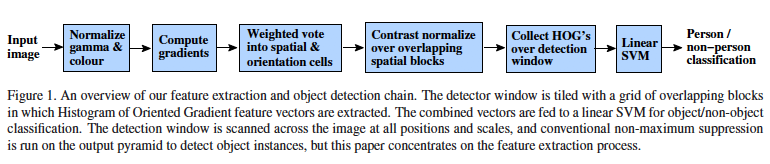

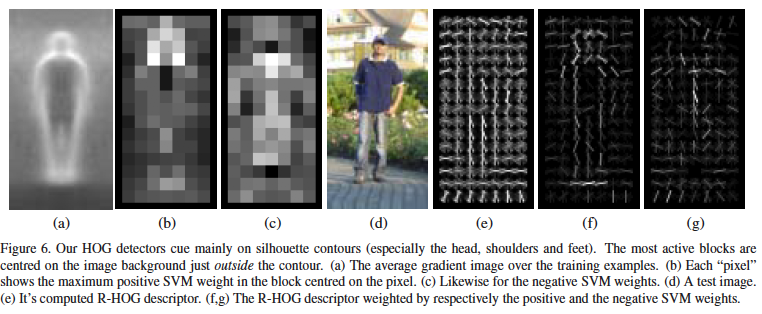

# People detection using HOG

We can use the HOG features to detect objects, i.e., people in images. 

1. Train an SVM classifier to take in a fixed-sized window and classify it as containing human or not. 
2. Use the sliding window technique to detect people across the whole image. Place the window at a location in the image, classify the region, and then slide over by "stride" number of pixel, classify, slide, etc.
3. We can do these operations on multiple scales of an image pyramid to find the shape at various scales.



In [9]:
# Code to remove overlapping bounding boxes. This is used by the next cell
# https://www.computervisionblog.com/2011/08/blazing-fast-nmsm-from-exemplar-svm.html
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")


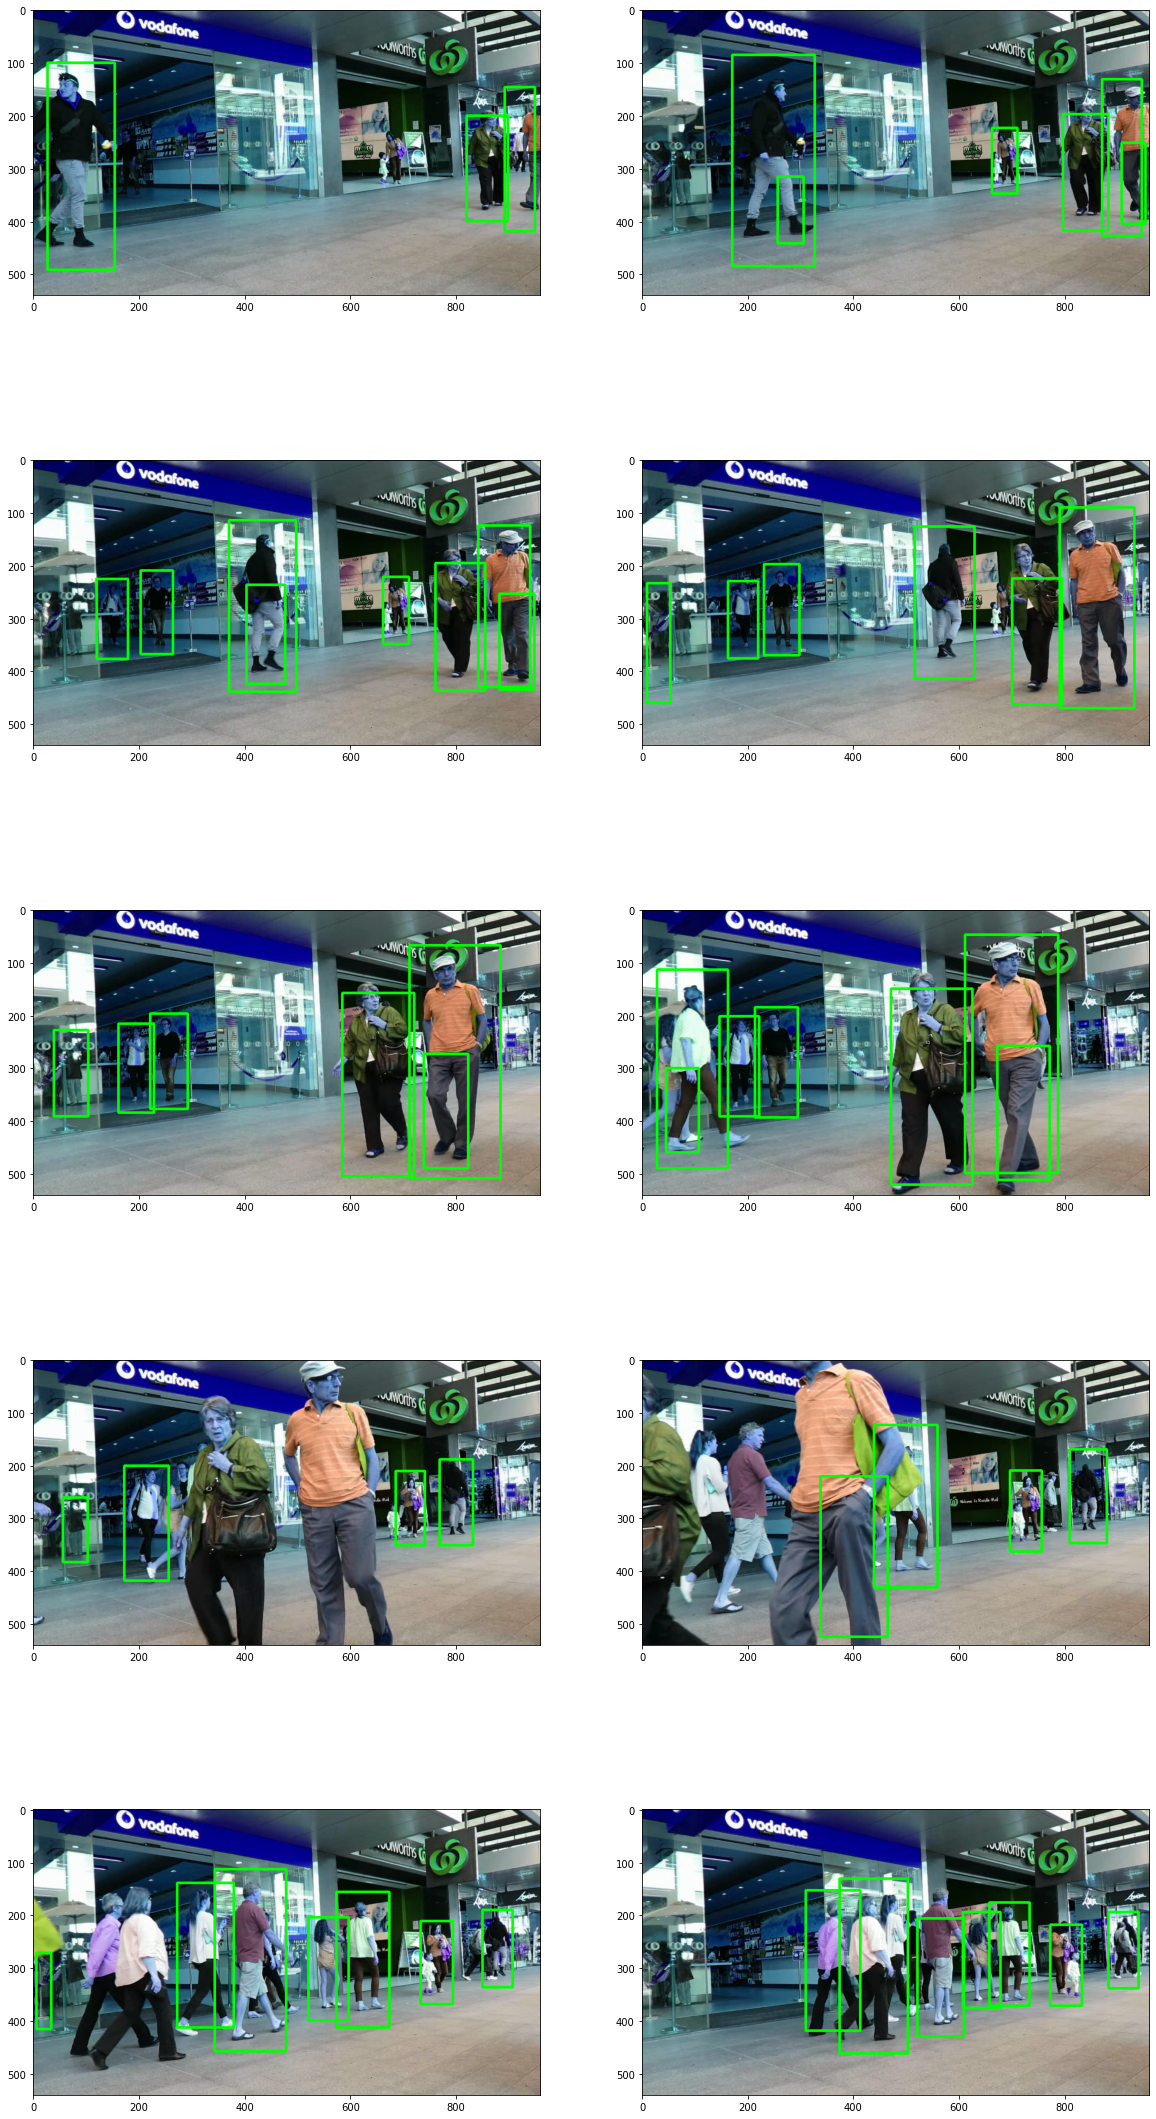

In [10]:
# (Python) An example applying the HOG descriptor for people detection can be 
# found at opencv_source_code/samples/python/peopledetect.py
# See: https://docs.opencv.org/master/de/da6/classcv_1_1cuda_1_1HOG.html and
# 
#
#-------------------------------------------------------------------------------
def draw_detections(img, rects, thickness = 1):
# This function is taken from OpenCV
    for x, y, w, h in rects:
        # the HOG detector returns slightly larger rectangles than the real objects.
        # so we slightly shrink the rectangles to get a nicer output.
        pad_w, pad_h = int(0.15*w), int(0.05*h)
        cv2.rectangle(img, (x+pad_w, y+pad_h), (x+w-pad_w, y+h-pad_h), (0, 255, 0), thickness)
#-------------------------------------------------------------------------------
hog = cv2.HOGDescriptor()
# See https://docs.opencv.org/master/d5/d33/structcv_1_1HOGDescriptor.html
# for more details about this class. 

hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector()) 

cap = cv2.VideoCapture('https://motchallenge.net/sequenceVideos/MOT16-09-raw.webm')

plt.figure(figsize=(20,40))

for i in range (10) :
    for j in range (25) : # skip 25 frames
        ret, current_frame = cap.read()
    #current_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
        
    found, _w = hog.detectMultiScale(current_frame, winStride=(8,8), padding=(32,32), scale=1.1)
    # Detects objects of different sizes in the input image. The detected objects are returned as a 
    # list of rectangles. Returns a vector of rectangles where each rectangle contains the detected object.
    # along with confidences (_w) -- distance from SVM boundary
    # https://docs.opencv.org/master/d5/d33/structcv_1_1HOGDescriptor.html#a660e5cd036fd5ddf0f5767b352acd948
    # 
    # virtual void cv::HOGDescriptor::detectMultiScale	(InputArray 	img,
    # std::vector< Rect > & 	foundLocations,
    # double 	hitThreshold = 0,
    # Size 	winStride = Size(),
    # Size 	padding = Size(),
    # double 	scale = 1.05,
    # double 	finalThreshold = 2.0,
    # bool 	useMeanshiftGrouping = false 
    # )		cons
    # The parameters of this function is explained well at 
    # https://www.pyimagesearch.com/2015/11/16/hog-detectmultiscale-parameters-explained/
    # "Tune your scale  and winStride  parameters. These two arguments have a tremendous impact 
    # on your object detector speed. Both scale  and winStride  should be as large as possible, 
    # again, without sacrificing detector accuracy. Keep in mind that for each layer of the pyramid a 
    # sliding window with winStride  steps is moved across the entire layer. While it’s important to evaluate 
    # multiple layers of the image pyramid, allowing us to find objects in our image at different scales, 
    # it also adds a significant computational burden since each layer also implies a series of sliding 
    # windows, HOG feature extractions, and decisions by our SVM must be performed."
    #
    # Typical values for scale  are normally in the range [1.01, 1.5]. 
    
    found_filtered = non_max_suppression_fast(found, overlapThresh=0.65)

    #draw_detections(current_frame, found, 1)
    draw_detections(current_frame, found_filtered, 3)
    #!print('%d (%d) found' % (len(found_filtered), len(found)))
    plt.subplot(5,2,i+1)
    plt.imshow(current_frame)

cap.release()
cv2.destroyAllWindows()
